<a href="https://colab.research.google.com/github/dyvanoff/Diplo2020Grupo3/blob/master/AnalisisyCuracion/Grupo3_Importando_los_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza de datos

Vamos a aplicar el [checklist del Banco Mundial](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning) en Python usando el [SciPy stack](https://www.scipy.org/stackspec.html), principalmente pandas

## 0. Prerequisitos

Aclaración: La próxima celda es para compatilibidad con Colab, NO ES RECOMENDADO realizar pip install desde un notebook.

In [2]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  BASE_DIR = "https://github.com/DiploDatos/AnalisisYCuracion/raw/master/"
else:
  BASE_DIR = ".."
if 'ftfy' not in sys.modules:
    !pip install 'ftfy<5.6'

     |████████████████████████████████| 51kB 1.7MB/s 


# 1. Importando los datos

# 1.1. Verificar que no hay problemas en la importación

In [3]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

Veamos de importar datos de proyectos de Kickstarter la plataforma de Crowdsourcing

In [4]:
##Este falla por: 
### UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 11: invalid start byte ###

#kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv")

Por defecto Pandas falla si hay errores para leer datos https://pandas.pydata.org/pandas-docs/stable/io.html#error-handling

Por ahora cambiamos a un archivo más actualizado, volveremos a este error más adelante

In [5]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv")

Veamos los datos cargados en el dataframe

In [6]:
kickstarter_2018

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00


Por defecto solo vemos los valores al comienzo o al final del archivo.

Tomemos una muestra al azar para ver valores más dispersos

In [7]:
# set seed for reproducibility
import numpy as np
np.random.seed(0)

In [8]:
kickstarter_2018.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
338862,796196901,10G Christmas Tree,Art,Art,USD,2010-12-26,10526.00,2010-12-08 08:44:04,0.00,failed,0,US,0.00,0.00,10526.00
277871,483825010,Gliff,Gaming Hardware,Games,USD,2016-03-28,10000.00,2016-01-28 04:56:18,51.00,failed,5,US,51.00,51.00,10000.00
47000,123916947,STUFFED Food Truck,Food Trucks,Food,USD,2015-01-06,60000.00,2014-11-07 02:24:36,25.00,failed,1,US,25.00,25.00,60000.00
111338,1565733636,NeoExodus Adventure: Origin of Man for Pathfin...,Tabletop Games,Games,USD,2012-05-01,500.00,2012-03-15 01:16:10,585.00,successful,17,US,585.00,585.00,500.00
53743,1273544891,NAPOLEON IN NEW YORK! an original TV Series,Comedy,Film & Video,USD,2016-07-26,25000.00,2016-05-27 00:07:25,25.00,failed,1,US,25.00,25.00,25000.00


No se observa a simple vista ningún problema obvio.

Notar que todos vimos los mismos resultados. Al fijar la semilla no hubo tal azar, esto es algo necesario cuando queremos "reproducir valores aleatorios"

Veamos la descripción del dataset si se corresponde con lo levantado https://www.kaggle.com/kemical/kickstarter-projects/data

In [9]:
pd.DataFrame([["ID", "No description provided", "Numeric"],
["name", "No description provided", "String"],
["category", "No description provided", "String"],
["main_category", "No description provided", "String"],
["currency", "No description provided", "String"],
["deadline", "No description provided", "DateTime"],
["goal", "Goal amount in project currency", "Numeric"],
["launched", "No description provided", "DateTime"],
["pledged", "Pledged amount in the project currency", "Numeric"],
["state", "No description provided", "String"],
["backers", "No description provided", "Numeric"],
["country", "No description provided", "String"],
["usd pledged", "Pledged amount in USD (conversion made by KS)", "Numeric"],
["usd_pledged_real", "Pledged amount in USD (conversion made by fixer.io api)", "Numeric"],
["usd_goal_real", "Goal amount in USD", "Numeric"]], columns=["Field name","Field description", "Type"])

,Field name,Field description,Type
0,ID,No description provided,Numeric
1,name,No description provided,String
2,category,No description provided,String
3,main_category,No description provided,String
4,currency,No description provided,String
5,deadline,No description provided,DateTime
6,goal,Goal amount in project currency,Numeric
7,launched,No description provided,DateTime
8,pledged,Pledged amount in the project currency,Numeric
9,state,No description provided,String


Ahora veamos los tipos de datos que detectó pandas

In [10]:
kickstarter_2018.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

Los campos object generalmente son String, entonces parece que no reconoció como fechas en **deadline** y **launched** :(

Veamos los datos un resumen de los datos

In [11]:
kickstarter_2018.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378661.00,378661.00,378661.00,374864.00,378661.00,378661.00
mean,1074731191.99,49080.79,9682.98,105.62,7036.73,9058.92,45454.40
std,619086204.32,1183391.26,95636.01,907.19,78639.75,90973.34,1152950.06
min,5971.00,0.01,0.00,0.00,0.00,0.00,0.01
25%,538263516.00,2000.00,30.00,2.00,16.98,31.00,2000.00
50%,1075275634.00,5200.00,620.00,12.00,394.72,624.33,5500.00
75%,1610148624.00,16000.00,4076.00,56.00,3034.09,4050.00,15500.00
max,2147476221.00,100000000.00,20338986.27,219382.00,20338986.27,20338986.27,166361390.71


Por defecto se ven los datos numéricos, veamos el resto.

In [12]:
kickstarter_2018.describe(include=['object'])

,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


Operemos un cacho sobre los datos de lanzamiento

In [13]:
kickstarter_2018['launched'].min()

'1970-01-01 01:00:00'

Parece funcionar, pero ahora calculemos el rango de fechas de los proyectos

In [14]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min()
#Este falla ya que no son fechas para pandas

TypeError: ignored

Indiquemos que columnas son fechas como indica la [documentación](https://pandas.pydata.org/pandas-docs/stable/io.html#datetime-handling)

In [15]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"]) #Leemos las fechas como tal
kickstarter_2018.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Ahora vemos que esas columnas fueron reconocidas como fechas

Veamos la misma muestra de nuevo

In [16]:
kickstarter_2018.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
299667,595962034,Button Poetry Live!,Mixed Media,Art,USD,2015-09-18,10000.00,2015-08-19 19:34:20,18216.27,successful,455,US,18216.27,18216.27,10000.00
181674,1924707671,"C STREET 2012 : Tbilisi, Georgia",World Music,Music,USD,2012-06-07,5000.00,2012-05-08 18:22:59,7210.69,successful,82,US,7210.69,7210.69,5000.00
137583,1698707842,Dérive's Next Project,Punk,Music,USD,2014-07-06,1200.00,2014-06-08 17:58:37,1255.66,successful,33,US,1255.66,1255.66,1200.00
296861,581269566,Photo Book - World Santa Claus Congress,Photobooks,Photography,DKK,2017-04-14,110000.00,2017-03-14 23:45:35,462.00,failed,5,DK,0.00,66.46,15823.47
66362,1337585114,Kickstart CLE Brewing to greatness!,Drinks,Food,USD,2017-08-19,6500.00,2017-07-20 21:22:43,250.00,failed,5,US,75.00,250.00,6500.00


Y veamos el resumen de los datos

In [17]:
kickstarter_2018.describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378657,378661,378661,378661,378661,378661.00,378661,378661.00,378661,378661.00,378661,374864.00,378661.00,378661.00
unique,nan,375764,159,15,14,3164,nan,378089,nan,6,nan,23,nan,nan,nan
top,nan,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08 00:00:00,nan,1970-01-01 01:00:00,nan,failed,nan,US,nan,nan,nan
freq,nan,41,22314,63585,295365,705,nan,7,nan,197719,nan,292627,nan,nan,nan
first,nan,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,nan,1970-01-01 01:00:00,nan,NaN,nan,NaN,nan,nan,nan
last,nan,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,nan,2018-01-02 15:02:31,nan,NaN,nan,NaN,nan,nan,nan
mean,1074731191.99,NaN,NaN,NaN,NaN,NaN,49080.79,NaN,9682.98,NaN,105.62,NaN,7036.73,9058.92,45454.40
std,619086204.32,NaN,NaN,NaN,NaN,NaN,1183391.26,NaN,95636.01,NaN,907.19,NaN,78639.75,90973.34,1152950.06
min,5971.00,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.01
25%,538263516.00,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,30.00,NaN,2.00,NaN,16.98,31.00,2000.00


Podemos ver que tenemos primero y último en el resumen de las columnas de fechas.

Ahora deberíamos poder calcular el rango de fechas de lanzamietos

In [18]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min()

Timedelta('17533 days 14:02:31')

# 1.2. Asegurar de tener ids/claves únicas

Chequear que no hay datos duplicados

In [19]:
kickstarter_2018.shape

(378661, 15)

Pandas soporta índices en los DataFrames vamos a recargar el conjunto de datos

In [20]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"], #Leemos las fechas como tal
                               index_col=['ID']) #Leemos los ID como tal

In [21]:
kickstarter_2018

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00


In [22]:
kickstarter_2018.shape

(378661, 14)

De esta forma podemos buscar por el índice

In [23]:
kickstarter_2018.loc[999988282]

name                Nou Renmen Ayiti!  We Love Haiti!
category                              Performance Art
main_category                                     Art
currency                                          USD
deadline                          2011-08-16 00:00:00
goal                                          2000.00
launched                          2011-07-19 09:07:47
pledged                                        524.00
state                                          failed
backers                                            17
country                                            US
usd pledged                                    524.00
usd_pledged_real                               524.00
usd_goal_real                                 2000.00
Name: 999988282, dtype: object

También podemos verificar si hay filas de contenidos duplicado

In [24]:
kickstarter_2018[kickstarter_2018.duplicated()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,


Como Pandas acepta valores duplicados en los índices también debemos verificar ahí

In [25]:
pd.Series(kickstarter_2018.index,dtype=str).describe()

count        378661
unique       378661
top       923763010
freq              1
Name: ID, dtype: object

In [26]:
kickstarter_2018[kickstarter_2018.index.duplicated()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,


Repasamos con un ejemplo de juguete

In [27]:
csv='1,2\n3,3\n1,3'
print(csv)

1,2
3,3
1,3


In [28]:
from io import StringIO
df = pd.read_csv(StringIO(csv), names=['id','value'], index_col='id')
df

,value
id,
1,2
3,3
1,3


In [29]:
df[df.duplicated()]

,value
id,
1,3


In [30]:
df[df.index.duplicated(keep=False)]

,value
id,
1,2
1,3


In [31]:
kickstarter_2018[kickstarter_2018.name.duplicated(keep=False)].sort_values(['name'])

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
816998285,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-02-09,6500.00,2013-12-19 21:51:50,0.00,canceled,0,US,0.00,0.00,6500.00
815783250,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-03-01,6500.00,2014-01-03 20:39:16,37.00,failed,3,US,37.00,37.00,6500.00
1010584633,"""A Fresh Start""",Shorts,Film & Video,USD,2011-09-25,3000.00,2011-08-28 21:27:52,3000.00,successful,24,US,3000.00,3000.00,3000.00
713417995,"""A Fresh Start""",Documentary,Film & Video,USD,2013-03-27,5000.00,2013-01-26 03:51:47,1417.00,failed,26,US,1417.00,1417.00,5000.00
1880084695,"""American Sports Stories"" - An Athletic Quest",Shorts,Film & Video,USD,2015-08-26,100000.00,2015-06-27 02:02:00,100.00,failed,1,US,100.00,100.00,100000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329580179,xxx (Canceled),Art,Art,USD,2011-09-03,10000.00,2011-06-05 04:54:37,1151.00,canceled,18,US,1151.00,1151.00,10000.00
1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00
634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97


In [32]:
##Para hallar duplicados en 2 columnas
#kickstarter_2018[kickstarter_2018.duplicated(subset=['name','goal'], keep=False)].sort_values(['name'])

#### Ejercicio 1:

Armar una tabla con todos los proyectos con nombres duplicados, ordenados para revisar agrupados. 

In [33]:
dfdupname=kickstarter_2018[kickstarter_2018.name.duplicated(keep=False)]
dfdupname.sort_values(['name'])

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
816998285,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-02-09,6500.00,2013-12-19 21:51:50,0.00,canceled,0,US,0.00,0.00,6500.00
815783250,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-03-01,6500.00,2014-01-03 20:39:16,37.00,failed,3,US,37.00,37.00,6500.00
1010584633,"""A Fresh Start""",Shorts,Film & Video,USD,2011-09-25,3000.00,2011-08-28 21:27:52,3000.00,successful,24,US,3000.00,3000.00,3000.00
713417995,"""A Fresh Start""",Documentary,Film & Video,USD,2013-03-27,5000.00,2013-01-26 03:51:47,1417.00,failed,26,US,1417.00,1417.00,5000.00
1880084695,"""American Sports Stories"" - An Athletic Quest",Shorts,Film & Video,USD,2015-08-26,100000.00,2015-06-27 02:02:00,100.00,failed,1,US,100.00,100.00,100000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329580179,xxx (Canceled),Art,Art,USD,2011-09-03,10000.00,2011-06-05 04:54:37,1151.00,canceled,18,US,1151.00,1151.00,10000.00
1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00
634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97


# 1.3. Despersonalizar datos y guardarlos en un nuevo archivo

Hay muuuchas técnicas para despersonalizar datos.

Para ilustrar mostramos las ofrecidas por Google https://cloud.google.com/dlp/docs/transformations-reference:

* **Reemplazo**: Reemplaza cada valor de entrada con un valor determinado.
* **Ocultamiento**: Quita un valor y lo oculta.
* **Enmascaramiento con caracteres**: Enmascara una string por completo o parcialmente mediante el reemplazo de un número determinado de caracteres con un carácter fijo especificado..
* **Seudonimización mediante el reemplazo de un valor de entrada con un hash criptográfico**: Reemplaza valores de entrada con una string hexadecimal de 32 bytes mediante una clave de encriptación de datos.
* **Cambio de fechas**: Cambia las fechas por un número de días al azar, con la opción de ser coherente en el mismo contexto..
* **Seudonimización mediante el reemplazo con token de preservación de formato criptográfico**: Reemplaza un valor de entrada con un token, o valor sustituto, de la misma longitud mediante la encriptación de preservación de formato (FPE) con el modo de operación FFX. Esto permite que se use el resultado en sistemas con validación de formato o que necesitan aparecer como reales a pesar de que la información no se revela.
* **Valores de depósito con base en rangos de tamaño fijos**: Enmascara los valores de entrada y los reemplaza por depósitos, o rangos dentro de los cuales se encuentra el valor de entrada.
* **Valores de depósito con base en rangos de tamaño personalizados**: Valores de entrada de depósito con base en rangos configurables por el usuario y valores de reemplazo.
* **Extracción de datos de tiempo**: EExtrae o preserva una porción de los valores Date, Timestamp y TimeOfDay.

In [34]:
from hashlib import md5

In [35]:
##Este falla por: 
### TypeError: Unicode-objects must be encoded before hashing ###

#kickstarter_2018['name'].apply(md5)

In [36]:
##Este falla por: 
### AttributeError: 'float' object has no attribute 'encode' ###

#def hashit(val):
#    return md5(val.encode('utf-8'))

#kickstarter_2018['name'].apply(hashit)

In [37]:
##Este es para ver bien por qué falla, y el error viene en: 
### AttributeError: 'float' object has no attribute 'encode' ###

def hashit(val):
    try:
        return md5(val.encode('utf-8'))
    except Exception as e:
        print(val, type(val))
        raise(e)

kickstarter_2018['name'].apply(hashit)

nan <class 'float'>


AttributeError: ignored

In [38]:
#Ahora que ya conocemos el problema, hacemos el encoding (fila a fila), solucionando los problemas 

def hashit(val):
    if isinstance(val, float): 
        return str(val)
    return md5(val.encode('utf-8')).hexdigest()

kickstarter_2018['name'].apply(hashit)

ID
1000002330    a6828ae8a2eca25f0dd7035efc0af0a0
1000003930    81609b3bdc0b96f429672d69702f2524
1000004038    c12f5c3bace2f0213cdb2679a265dca0
1000007540    4dbdcf09c86bbf5683ec39bc57b77f81
1000011046    9c01404a2ef702811c2088ce139042ad
                            ...               
999976400     d89228576343394467096843057f3aa4
999977640     bbcb30bd9bd4f9bff0a96fc44d0001f0
999986353     6c3094666e1a315b6e179566fe3972d9
999987933     887be409ad8b93f26084845a41d4c178
999988282     11f7ae3385c567df409deb5f4ac9a2a5
Name: name, Length: 378661, dtype: object

#### Ejercicio 2:

Verificar que los proyectos que tienen nombres duplicados también tienen el hash de nombre duplicado

In [39]:
df = pd.DataFrame(kickstarter_2018['name'].apply(hashit))
df.columns = ['pseudoname']
df

,pseudoname
ID,
1000002330,a6828ae8a2eca25f0dd7035efc0af0a0
1000003930,81609b3bdc0b96f429672d69702f2524
1000004038,c12f5c3bace2f0213cdb2679a265dca0
1000007540,4dbdcf09c86bbf5683ec39bc57b77f81
1000011046,9c01404a2ef702811c2088ce139042ad
...,...
999976400,d89228576343394467096843057f3aa4
999977640,bbcb30bd9bd4f9bff0a96fc44d0001f0
999986353,6c3094666e1a315b6e179566fe3972d9


In [40]:
#Obtenemos hash name duplicados
dfduphash=df[df.pseudoname.duplicated(keep=False)]

In [41]:
#Esta función dice si son iguales los índices
if (dfduphash.index.equals(dfdupname.index)):
  print('Los índices son iguales') 
else:
   print('Los índices son distintos')

Los índices son iguales


In [42]:
#Mostramos las filas con nombres duplicados y hash de nombre duplicados ordenado por nombre. 
merged_inner = pd.merge(left=dfduphash, right=dfdupname.name, how='inner', left_on='ID', right_on='ID')
merged_inner.sort_values(['name'])

,pseudoname,name
ID,,
816998285,0c7a251ffe4c7834cbc4b04906952ff1,"""...The Last shall be first..."" LODB Lifestyle..."
815783250,0c7a251ffe4c7834cbc4b04906952ff1,"""...The Last shall be first..."" LODB Lifestyle..."
1010584633,67554ab4203d95f2f2f05365f768206e,"""A Fresh Start"""
713417995,67554ab4203d95f2f2f05365f768206e,"""A Fresh Start"""
1880084695,19a82bc4c5961834282575d07d9b5f7c,"""American Sports Stories"" - An Athletic Quest"
...,...,...
329580179,930857c212f21166427b23d4a7fe52a3,xxx (Canceled)
1848699072,nan,NaN
634871725,nan,NaN


# 1.4. Nunca modificar los datos crudos u originales


In [43]:
if not in_colab:
  kickstarter_2018.to_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv")


# 2. Pasos necesarios


In [44]:
if not in_colab:
  kickstarter_2018 = pd.read_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv",
                        index_col='ID',
                        parse_dates=['deadline','launched'])

In [45]:
kickstarter_2018.describe(include='all')

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378657,378661,378661,378661,378661,378661.00,378661,378661.00,378661,378661.00,378661,374864.00,378661.00,378661.00
unique,375764,159,15,14,3164,nan,378089,nan,6,nan,23,nan,nan,nan
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08 00:00:00,nan,1970-01-01 01:00:00,nan,failed,nan,US,nan,nan,nan
freq,41,22314,63585,295365,705,nan,7,nan,197719,nan,292627,nan,nan,nan
first,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,nan,1970-01-01 01:00:00,nan,NaN,nan,NaN,nan,nan,nan
last,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,nan,2018-01-02 15:02:31,nan,NaN,nan,NaN,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,49080.79,NaN,9682.98,NaN,105.62,NaN,7036.73,9058.92,45454.40
std,NaN,NaN,NaN,NaN,NaN,1183391.26,NaN,95636.01,NaN,907.19,NaN,78639.75,90973.34,1152950.06
min,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.01
25%,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,30.00,NaN,2.00,NaN,16.98,31.00,2000.00


## 2.1. Etiquetas de variables/columnas: no usar caracteres especiales



In [46]:
# helpful character encoding module
import chardet

¿Por qué? Por que aun hay limitaciones para trabajar con estos caracteres.

¿Cúales son los caracteres "normales"? 

In [47]:
import string

string.ascii_letters + string.digits

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

¿Qué es ASCII? Es una de las primeras codificaciones (o encoding) disponibles. Ver https://en.wikipedia.org/wiki/ASCII

Un encoding es un mapa de caracteres a una representación en bits (por ejemplo 1000001). ASCII es uno de los primeros estandares para interoperatividad entre computadoras (antes cada fabricante de computadora usa su propia codificación), contempla sólo los caracteres ingleses y usa 7 bits, por ejemplo *1000001* codifica el caracter *A*

Cómo sólo representaban los caracteres ingleses, empiezan a aparecer variantes para distintos idiomas, Microsoft hizo los propios para internacionalizar Windows, hubo otro estandar ISO 8859, hasta que llegó el éstandar Unicode que hizo múltiples encodings pero cada uno contempla múltiples idiomas e incluso es extensible a futuro. UTF-8 es de esos encodings el más utilizado. Ver https://en.wikipedia.org/wiki/Unicode

En particular, Python 3 utiliza UTF-8 por defecto (lo que no sucedía en Python 2).

Veamos un ejemplo práctico

In [48]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

In [49]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors = "replace")

# check the type
type(after)

bytes

In [50]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

In [51]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


In [52]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

UnicodeDecodeError: ignored

In [53]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


Este error ya lo vimos...

In [54]:
## Volverá a fallar po UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 11: invalid start byte
#kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv")

El error `UnicodeDecodeError` nos indica que el archivo no estaría en Unicode. Si no está en algún metadato o no fue indicado es dificil detectar el encoding, por suerte hay un paquete para esto en Python, que aplica unas heurísticas para detectar encoding.

In [55]:
# In Colab we need to download data locally
if in_colab:
  !wget -c $BASE_DIR/input/kickstarter-projects/ks-projects-201612.csv
  DOWN_DIR = "./"
else:
  DOWN_DIR = BASE_DIR + "/input/kickstarter-projects/"
  
# look at the first ten thousand bytes to guess the character encoding
with open(DOWN_DIR + "/ks-projects-201612.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
result

--2020-07-01 21:58:24--  https://github.com/DiploDatos/AnalisisYCuracion/raw/master//input/kickstarter-projects/ks-projects-201612.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DiploDatos/AnalisisYCuracion/master/input/kickstarter-projects/ks-projects-201612.csv [following]
--2020-07-01 21:58:25--  https://raw.githubusercontent.com/DiploDatos/AnalisisYCuracion/master/input/kickstarter-projects/ks-projects-201612.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46500324 (44M) [text/plain]
Saving to: ‘ks-projects-201612.csv’

ks-projects-201612. 100%[===================>]  44.35M  50.2MB/s    

{'confidence': 0.73, 'encoding': 'Windows-1252', 'language': ''}

Entonces le podemos indicar el encoding al leer el archivos

In [56]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,nan
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,nan
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,nan
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,nan
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,nan


Hay otro problema con los caracteres que es más sutíl: **[Mojibake](https://en.wikipedia.org/wiki/Mojibake)**

Sucede al leer UTF-8 como ASCII extendido (ie. `Windows-*`, `iso-8859-*` entre otros)

Ejemplo de mojibake:

In [57]:
"cigüeña".encode('utf-8').decode('iso-8859-1')

'cigÃ¼eÃ±a'

In [58]:
"cigÃ¼eÃ±a".encode('iso-8859-1').decode('utf-8')

'cigüeña'

Para esto vamos a usar un módulo específico [ftfy](https://ftfy.readthedocs.io/en/latest/). 

Que nos permite ordenar cadenas por rareza

In [59]:
import ftfy.badness as bad

In [60]:
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)


kickstarter_2018['name_weirdness'] = kickstarter_2018['name'].apply(weird)
kickstarter_2018[kickstarter_2018['name_weirdness'] > 1]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1221990593,Support PMCD´s ¨From a Different Clay¨,Dance,Dance,USD,2011-06-08,1500.00,2011-04-28 05:15:32,1940.00,successful,27,US,1940.00,1940.00,1500.00,3
1234089244,Cracking (Mastering) the Metaphor (Political)...,Nonfiction,Publishing,USD,2013-10-27,30000.00,2013-09-27 23:33:29,0.00,failed,0,US,0.00,0.00,30000.00,2
124795481,µGALE (Canceled),Wearables,Technology,EUR,2015-04-17,18000.00,2015-02-16 01:55:34,10.00,canceled,2,NL,11.39,10.81,19465.14,2
1468489999,µCurrent GOLD - Precision Multimeter Current A...,Hardware,Technology,AUD,2013-12-31,9900.00,2013-12-17 10:28:09,116575.17,successful,1268,AU,104343.69,104871.51,8906.08,2
1610503461,µPeek - The Professional Microscope that Fits ...,Technology,Technology,CHF,2016-01-09,125000.00,2015-12-10 10:08:18,247688.14,successful,1435,CH,249249.19,246848.85,124576.44,2
16174550,PARALELO 19 Nº,Photography,Photography,MXN,2017-04-15,15000.00,2017-03-01 00:00:24,3340.00,failed,8,MX,0.00,177.36,796.52,2
1719215256,Kickstarter Gold: Manual Coffeemaker Nº3,Product Design,Design,USD,2017-07-22,60000.00,2017-06-20 15:29:56,68587.33,successful,618,US,21002.00,68587.33,60000.00,2
1837094178,¨Midgard's taigh-seinnse/ Eröffnung Mittelalte...,Restaurants,Food,CHF,2016-09-29,50000.00,2016-08-30 09:36:42,150.00,failed,1,CH,0.00,153.93,51310.47,2
2056123754,ZEIº - the most simple time tracking solution,Technology,Technology,EUR,2016-10-26,75000.00,2016-09-20 15:54:49,313637.00,successful,3140,AT,9451.58,342555.54,81915.29,2


Volviendo a la consigna original, chequeamos que no haya caracteres fuera de a-Z, 0-9 y _ en los nombres de columnas

In [61]:
kickstarter_2018.columns[~kickstarter_2018.columns.str.match(r'^(\w+)$')]

Index(['usd pledged'], dtype='object')

In [62]:
kickstarter_2018.usd_pledged.head()

AttributeError: ignored

In [63]:
kickstarter_2018.columns = kickstarter_2018.columns.str.replace(' ', '_')
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [64]:
kickstarter_2018.usd_pledged.head()

ID
1000002330      0.00
1000003930    100.00
1000004038    220.00
1000007540      1.00
1000011046   1283.00
Name: usd_pledged, dtype: float64

#### Ejercicio 3

Comparar la cantidad de nombres raros en kickstarter_2018 con la que obtenemos al cargar 'ks-projects-201801.csv' con encoding iso-8859-1.

In [65]:
# read in the file with the encoding detected by chardet
kickstarter_2018_iso_8859_1 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", encoding='iso-8859-1')
# look at the first few lines
kickstarter_2018_iso_8859_1.sample(4)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
284129,515317667,Three Zombies in Philadelphia,Film & Video,Film & Video,USD,2013-05-29,20000.00,2013-03-30 19:36:04,29.99,failed,4,US,29.99,29.99,20000.00
187025,1952141049,Chroma Cafe and Bakery Hood and Expansion Project,Restaurants,Food,USD,2014-05-30,9750.00,2014-04-25 03:13:43,9900.00,successful,134,US,9900.00,9900.00,9750.00
231103,24476326,The L Train,Comedy,Film & Video,USD,2017-09-09,6000.00,2017-08-25 00:00:26,6065.00,successful,81,US,340.00,6065.00,6000.00
117045,1594525425,Slimo - Desktop Buddy,Software,Technology,USD,2017-11-01,250.00,2017-10-02 20:10:09,22.00,failed,3,US,10.00,22.00,250.00


In [66]:
kickstarter_2018_iso_8859_1['name_weirdness'] = kickstarter_2018_iso_8859_1['name'].apply(weird)
weird_iso = kickstarter_2018_iso_8859_1[kickstarter_2018_iso_8859_1['name_weirdness'] > 1][['name','name_weirdness']].sort_values(by=['name_weirdness'], ascending=False)

In [67]:
weird_win=kickstarter_2018[kickstarter_2018['name_weirdness'] > 1]

In [68]:
win = len(weird_win)
iso = len(weird_iso)
print('Diferencia en cantidades |WIN - ISO|: %i' %np.abs(iso - win))

Diferencia en cantidades |WIN - ISO|: 7656


## 2.2. Tratar valores faltantes

Veamos cuantos valores nulos tenemos

In [69]:
# get the number of missing data points per column
missing_values_count = kickstarter_2018.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[missing_values_count > 0]

name              4
usd_pledged    3797
dtype: int64

Esta medida en sí, no dice nada más que con cuantos valores debemos lidiar. 

Primero tenemos que ver si en términos relativos su impacto.

In [70]:
len(kickstarter_2018.dropna())/len(kickstarter_2018)

0.9899619976707398

In [71]:
len(kickstarter_2018.dropna(subset=['name']))/len(kickstarter_2018)

0.9999894364616372

También debemos ver que significan en términos de representatividad e importancia de nuestro análisis.

In [72]:
kickstarter_2018[kickstarter_2018.name.isnull()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00,0
634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97,0
648853978,NaN,Product Design,Design,USD,2016-07-18,2500.00,2016-06-18 05:01:47,0.00,suspended,0,US,0.00,0.00,2500.00,0
796533179,NaN,Painting,Art,USD,2011-12-05,35000.00,2011-11-06 23:55:55,220.00,failed,5,US,220.00,220.00,35000.00,0


Ejemplo, cuantos de los proyectos suspendidos no tienen nombre

In [73]:
len(kickstarter_2018[kickstarter_2018.state == 'suspended'].dropna(subset=['name'])) / \
    len(kickstarter_2018[kickstarter_2018.state == 'suspended'])

0.9994582881906826

En este caso, creemos que es seguro descartar los proyectos sin nombre

In [74]:
kickstarter_2018 = kickstarter_2018.dropna(subset=['name'])

In [75]:
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

usd_pledged    3797
dtype: int64

In [76]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.00,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",nan,555.00,6500.00,0
100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",nan,3402.08,3211.53,0
1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",nan,3576.00,3500.00,0
1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.00,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",nan,7007.80,6000.00,0
1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.00,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",nan,3660.38,3000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.00,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",nan,10.00,7500.00,-1
998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.00,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",nan,2845.61,2752.04,0
9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.00,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",nan,235.00,5000.00,0


In [77]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()].describe(include='all')

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
count,3797,3797,3797,3797,3797,3797.00,3797,3797.00,3797,3797.00,3797,0.00,3797.00,3797.00,3797.00
unique,3764,28,12,10,722,nan,3797,nan,6,nan,1,nan,nan,nan,nan
top,New EP/Music Development,Music,Music,USD,2015-05-01 00:00:00,nan,2015-10-27 17:00:11,nan,undefined,nan,"N,0""",nan,nan,nan,nan
freq,28,2387,2388,2738,26,nan,1,nan,3562,nan,3797,nan,nan,nan,nan
first,NaN,NaN,NaN,NaN,2012-04-24 00:00:00,nan,2012-03-14 19:05:44,nan,NaN,nan,NaN,nan,nan,nan,nan
last,NaN,NaN,NaN,NaN,2016-07-07 00:00:00,nan,2016-05-21 20:45:12,nan,NaN,nan,NaN,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,5413.35,NaN,3023.26,NaN,0.00,NaN,nan,2949.85,5097.31,-0.01
std,NaN,NaN,NaN,NaN,NaN,37466.24,NaN,44919.41,NaN,0.00,NaN,nan,44881.72,37258.79,0.12
min,NaN,NaN,NaN,NaN,NaN,108.00,NaN,0.00,NaN,0.00,NaN,nan,0.00,85.28,-3.00
25%,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,5.00,NaN,0.00,NaN,nan,5.00,2250.00,0.00


Interesante, todos los datos pertenecen a un país indeterminado.

Todos los datos de ese "país" no tienen dinero prometido?

In [78]:
kickstarter_2018[(kickstarter_2018.country == 'N,0"') & ~(kickstarter_2018.usd_pledged.isnull())].head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,


A priori como los proyectos no tienen patrocinantes, completamos en 0 los valores

In [79]:
kickstarter_2018 = kickstarter_2018.fillna(0)
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

Series([], dtype: int64)

In [80]:
kickstarter_2018.shape

(378657, 15)

Más métodos disponibles en https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-missing y http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

## 2.3. Codificar variables

Para trabajar con los algoritmos de aprendizaje automático, las variables categóricas estas deben ser codificadas como variables numéricas, no como cadenas.

Para esta tarea también hay diferentes estrategias, dos comunes son: asociar cadena a número y asociar cadena a columna.

In [81]:
from sklearn import preprocessing

In [82]:
kickstarter_2018.describe(include=['O'])

,name,category,main_category,currency,state,country
count,378657,378657,378657,378657,378657,378657
unique,375764,159,15,14,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,failed,US
freq,41,22313,63584,295362,197716,292624


In [83]:
column='main_category'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(kickstarter_2018[column])

LabelEncoder()

In [84]:
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'Art': 0,
 'Comics': 1,
 'Crafts': 2,
 'Dance': 3,
 'Design': 4,
 'Fashion': 5,
 'Film & Video': 6,
 'Food': 7,
 'Games': 8,
 'Journalism': 9,
 'Music': 10,
 'Photography': 11,
 'Publishing': 12,
 'Technology': 13,
 'Theater': 14}

In [85]:
# Apply the fitted encoder to the pandas column
kickstarter_2018[column] = le.transform(kickstarter_2018[column]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,12,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,6,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,6,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,10,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,6,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [86]:
# Reversing encoding
kickstarter_2018[column] = le.inverse_transform(kickstarter_2018[column]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [87]:
from sklearn.preprocessing import LabelBinarizer
other_column = 'state'

lb = LabelBinarizer()

lb_results = lb.fit_transform(kickstarter_2018[other_column])
pd.DataFrame(lb_results, columns=((other_column + '_') + pd.Series(lb.classes_))).head(10)

,state_canceled,state_failed,state_live,state_successful,state_suspended,state_undefined
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0
5,0,0,0,1,0,0
6,0,0,0,1,0,0
7,0,1,0,0,0,0
8,1,0,0,0,0,0
9,1,0,0,0,0,0


More about preprocessing in http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

#### Ejercicio 4

Codificar `currency` con ambas estrategias

In [88]:
column='currency'
# Create a label (category) encoder object
le_currency = preprocessing.LabelEncoder()
# Fit _cthe encoder to the pandas column
le_currency.fit(kickstarter_2018[column])

LabelEncoder()

In [89]:
dict(zip(le_currency.classes_,le_currency.transform(le_currency.classes_)))

{'AUD': 0,
 'CAD': 1,
 'CHF': 2,
 'DKK': 3,
 'EUR': 4,
 'GBP': 5,
 'HKD': 6,
 'JPY': 7,
 'MXN': 8,
 'NOK': 9,
 'NZD': 10,
 'SEK': 11,
 'SGD': 12,
 'USD': 13}

In [90]:
# Apply the fitted encoder to the pandas column
kickstarter_2018[column] = le_currency.transform(kickstarter_2018[column]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,5,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,13,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,13,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,13,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,13,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


In [91]:
# Reversing encoding
kickstarter_2018[column] = le_currency.inverse_transform(kickstarter_2018[column]) 
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


Ahora aplicamos binarizado

In [92]:
other_column = 'currency'

lb_currency = LabelBinarizer()

lb_results = lb_currency.fit_transform(kickstarter_2018[other_column])
pd.DataFrame(lb_results, columns=((other_column + '_') + pd.Series(lb_currency.classes_))).head(10)

,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 2.4. No cambiar los nombres de las variables de la fuente de origen


## 2.5. Verificar la consistencia de las variables
Aplicar reglas de integridad


In [93]:
kickstarter_2018.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0


¿Hay proyectos sin patrocinadores pero con plata prometida?

In [94]:
kickstarter_2018[(kickstarter_2018.backers == 0) & (kickstarter_2018.usd_pledged > 0)]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
100173829,La Press: Make Soap at Home in 2 minutes. No C...,Gadgets,Technology,CAD,2017-11-11,40000.00,2017-09-12 05:11:01,0.00,failed,0,CA,86.46,0.00,31343.05,0
1004972393,AlwaysRemembered.com The new way to remember o...,Web,Technology,AUD,2017-05-15,100000.00,2017-04-15 09:17:40,0.00,failed,0,AU,18.93,0.00,74371.56,0
1006945199,Have your Cake and Eat it too!,Food,Food,USD,2016-12-05,10000.00,2016-11-05 20:16:29,0.00,canceled,0,US,24.00,0.00,10000.00,0
1019661678,Presidential Pareidolia,Digital Art,Art,USD,2017-05-14,66600.00,2017-04-14 23:13:10,0.00,failed,0,US,25.00,0.00,66600.00,0
1031663961,The Lite Bros. Series,Comics,Comics,USD,2017-05-09,10000.00,2017-04-09 02:20:51,0.00,failed,0,US,25.00,0.00,10000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928930112,"Hitchhike for 5,610 miles and try to reach Ell...",Documentary,Film & Video,SEK,2017-03-06,45000.00,2017-01-05 14:18:14,0.00,failed,0,SE,10.91,0.00,4983.11,0
930939140,RetroNemesis Arcade Clothing Line,Apparel,Fashion,USD,2017-05-12,750.00,2017-04-12 21:18:11,0.00,failed,0,US,25.00,0.00,750.00,0
945359364,Painting the faces of strangers,Digital Art,Art,GBP,2017-12-04,50.00,2017-11-03 23:48:24,0.00,failed,0,GB,53.12,0.00,67.08,0


¿Hay proyecto no exitosos que pasaron el objetivo?

In [95]:
kickstarter_2018[(kickstarter_2018.state != 'successful') & (kickstarter_2018.pledged > kickstarter_2018.goal)]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.00,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",0.00,3402.08,3211.53,0
1001732009,DotPen : Redefines drawing and writing for sma...,Product Design,Design,USD,2014-08-09,25000.00,2014-06-30 21:17:10,39693.00,suspended,647,US,39693.00,39693.00,25000.00,0
1002379225,"The World's First Genuine, Intuitively-control...",Technology,Technology,USD,2017-06-15,5000.00,2017-05-01 18:37:51,61416.00,canceled,103,US,13700.00,61416.00,5000.00,0
1002854072,Spycup turns your iPhone into a hidden camera ...,Gadgets,Technology,CAD,2015-12-19,5000.00,2015-11-19 17:26:34,6672.00,canceled,115,CA,5006.57,4810.38,3604.90,0
1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.00,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",0.00,3576.00,3500.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997445060,The Every Day Carry Sling Belt (Canceled),Fashion,Fashion,USD,2012-05-28,1000.00,2012-04-28 07:12:06,1358.00,canceled,35,US,1358.00,1358.00,1000.00,0
997554968,Susan Picking: Making Music with Kids in the S...,Music,Music,USD,2015-03-01,8000.00,2015-01-31 20:58:01,8582.00,undefined,0,"N,0""",0.00,8582.00,8000.00,0
997915422,Otter's First Full Length Album,Music,Music,USD,2015-12-31,5000.00,2015-12-01 00:25:06,6065.26,undefined,0,"N,0""",0.00,6065.26,5000.00,0


¿Cómo es, en promedio, la correlación entre el objetivo y la plata obtenida?

In [96]:
df = kickstarter_2018.groupby('state')[['goal','pledged']].aggregate('mean')
df['pledged'] / df['goal']

state
canceled     0.03
failed       0.02
live         0.12
successful   2.37
suspended    0.06
undefined    0.52
dtype: float64

¿Cuánta plata se obtiene en promedio por estado y categoría?

In [97]:
kickstarter_2018.pivot_table(values='usd_pledged',index='state',columns='main_category')

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
canceled,405.94,722.46,342.51,455.18,3361.22,996.49,1468.05,715.49,3312.50,198.61,585.91,418.70,451.11,3959.58,1472.81
failed,554.10,869.11,263.54,555.21,2353.08,686.00,1368.40,927.01,1970.92,452.95,557.37,565.53,539.22,2018.73,892.50
live,887.49,934.78,95.43,182.59,3559.01,443.48,336.93,1014.11,1678.80,762.78,434.78,832.48,1031.71,2028.49,479.18
successful,5420.99,9178.68,4053.92,4445.79,43545.99,15136.85,12403.29,14227.41,41643.05,8598.27,6283.11,7897.06,7257.91,67226.64,5289.17
suspended,436.70,347.47,201.33,320.43,11471.42,3539.29,2463.24,2708.65,2497.19,44.77,340.77,159.96,422.83,22953.52,57.08
undefined,nan,nan,nan,0.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00


#### Ejercicio 5

1. ¿Hay proyecto éxitosos que no consiguieron el objetivo? Si hay, ¿Qué porcentaje sí y cuál no?
2. Calcular una tabla con la cantidad de proyectos por categoría principal y estado.

In [98]:
#Proyectos que son 'successful0, pero con 'pledged'<'goal'
kickstarter_2018[(kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged < kickstarter_2018.goal)]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1368992939,Santa's Sled,Art,Art,USD,2012-08-27,3600.00,2012-07-26 03:31:28,3599.69,successful,64,US,3599.69,3599.69,3600.00,0
1769772834,Borders of the Imagination - An Epic Sci-Fi/Fa...,Shorts,Film & Video,USD,2015-12-27,36000.00,2015-11-12 19:06:18,30716.00,successful,275,US,30716.00,30716.00,36000.00,0
251325270,Documentary film about Les Blank.,Documentary,Film & Video,USD,2010-07-18,8000.00,2010-06-02 22:15:38,7999.65,successful,73,US,7999.65,7999.65,8000.00,0
4732285,Insiders/Out: Exploring Outsider Art in America,Art,Art,USD,2010-07-08,2000.00,2010-05-27 00:26:33,1999.66,successful,30,US,1999.66,1999.66,2000.00,0
780863434,TUW Ruhla Watches - Comeback of a Legend,Product Design,Design,EUR,2016-03-19,25000.00,2016-02-08 19:14:02,24892.50,successful,90,DE,27778.24,27765.07,27884.98,0


In [99]:
#Veamos el porcentaje
Porcentaje = 100/(kickstarter_2018.state == 'successful').sum() * ((kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged > kickstarter_2018.goal)).sum()
print('Consigió Objetivo    : %2.2f %%' 
      %Porcentaje)
print('No Consigió Objetivo : %2.2f %%' 
      %(100-Porcentaje))

Consigió Objetivo    : 96.97 %
No Consigió Objetivo : 3.03 %


Tabla con la cantidad de proyectos por categoría principal y estado.

In [100]:
kickstarter_2018.pivot_table(values='currency',index='state',columns='main_category', aggfunc='count')

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
state,,,,,,,,,,,,,,,
canceled,2222.00,842.00,843.00,163.00,4152.00,2650.00,5755.00,2211.00,6202.00,523.00,3305.00,986.00,3602.00,4715.00,608.00
failed,14130.00,4036.00,5703.00,1235.00,14814.00,14182.00,32903.00,15969.00,16002.00,3137.00,21752.00,6384.00,23145.00,20616.00,3708.00
live,194.00,76.00,76.00,18.00,305.00,250.00,332.00,184.00,287.00,31.00,281.00,48.00,299.00,377.00,41.00
successful,11510.00,5842.00,2115.00,2338.00,10550.00,5593.00,23623.00,6085.00,12518.00,1012.00,24197.00,3305.00,12300.00,6434.00,6534.00
suspended,96.00,23.00,72.00,13.00,246.00,138.00,117.00,153.00,220.00,52.00,149.00,55.00,66.00,424.00,21.00
undefined,nan,nan,nan,1.00,2.00,3.00,854.00,nan,1.00,nan,2234.00,1.00,462.00,3.00,1.00


## 2.6. Identificar y documentar valores atípicos/outliers


Queremos analizar las características de los proyectos que obtienen dinero pero sin considerar los casos atípicos.

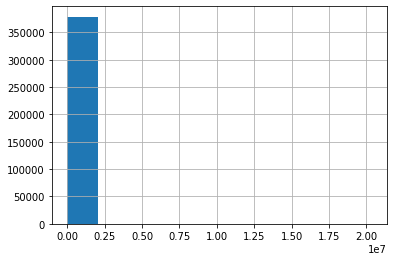

In [101]:
%matplotlib inline
kickstarter_2018.usd_pledged.hist();

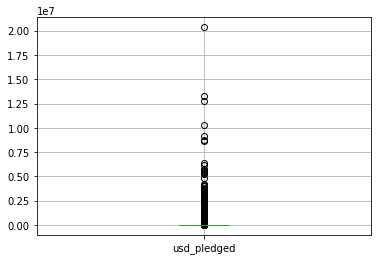

In [102]:
kickstarter_2018.boxplot(column='usd_pledged');

"There are many rules of thumb for how to define an outlier but there is no silver bullet. One rule of thumb is that any data point that is three standard deviations away from the mean of the same data point for all observations."

In [112]:
outliers = kickstarter_2018[(np.abs(kickstarter_2018.usd_pledged 
                                       - kickstarter_2018.usd_pledged.mean()) <= (3 * kickstarter_2018.usd_pledged.std()))]
outliers

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00,0
999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00,0
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00,0


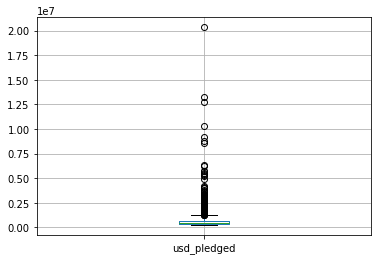

In [113]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd_pledged');

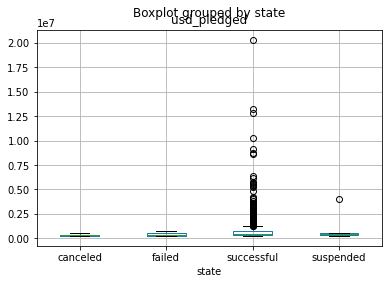

In [114]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd_pledged',by='state');

Analizar outliers por categorías

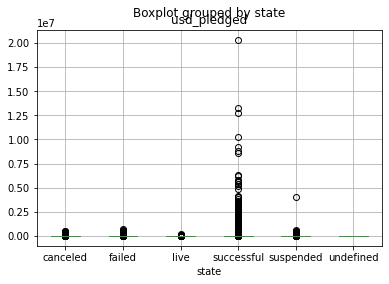

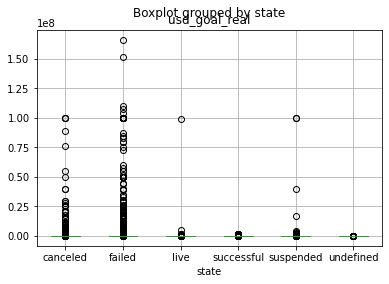

In [115]:
kickstarter_2018.boxplot(column='usd_pledged',by='state');
kickstarter_2018.boxplot(column='usd_goal_real',by='state');

#### Ejercicio 6

Calcular los valores atípicos de 'usd_goal_real' y graficar los boxplots, con y sin estos valores por categoría principal

In [116]:
outliers2 = kickstarter_2018[(np.abs(kickstarter_2018.usd_goal_real 
                                       - kickstarter_2018.usd_goal_real.mean()) <= (3 * kickstarter_2018.usd_goal_real.std()))]
outliers2
print('Cantidad de outliers de "usd_goal_real"', len(outliers2))
outliers2

Cantidad de outliers de "usd_goal_real" 378285


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real,name_weirdness
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,0
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,0
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,0
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,0
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00,0
999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00,0
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00,0


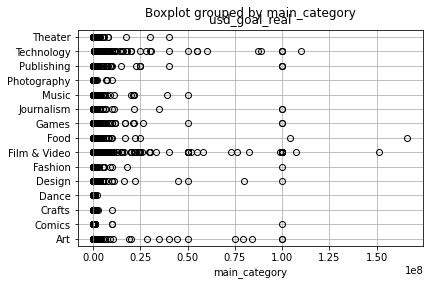

In [117]:
#Boxplot de "usd_goal_real" con outliers
kickstarter_2018.boxplot(column='usd_goal_real',by='main_category', vert=False);

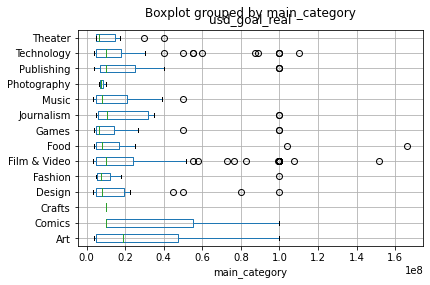

In [119]:
#Boxplot de "usd_goal_real" sin outliers globales
kickstarter_2018.drop(outliers2.index).boxplot(column='usd_goal_real',by='main_category', vert=False);

## 2.7. Evaluar cómo comprimir los datos 
para su almacenamiento más eficiente.

En la actualidad, en las nubes el almacenamiento no suele ser problema sino la velocidad para leerlo que suele ser determinante a la hora de determinar el formato de almacenamiento.


## 2.8. Guardar el set de datos con un nombre informativo.


EL problema de la ingeniería de software